In [17]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
import paddle
import paddle.fluid as fluid 

In [2]:
get_ipython().system('unzip -qo -d data data/data101646/stock_LSTM_fluid.zip')

In [19]:
SAVE_DIRNAME = 'data/stock_LSTM_fluid/model'
f = open('data/stock_LSTM_fluid/datasets/stock_dataset.txt') 
df = f.readlines()    
f.close()

In [20]:
data = []
for line in df:
    data_raw = line.strip('\n').strip('\r').split('\t') #这里data_raw是列表形式，代表一行数据样本
    data.append(data_raw)#data为二维列表形式
data = np.array(data, dtype='float32')

In [21]:
print('数据类型：',type(data))
print('数据个数：', data.shape[0])
print('数据形状：', data.shape)
print('数据第一行：', data[0])


数据类型： <class 'numpy.ndarray'>
数据个数： 6109
数据形状： (6109, 8)
数据第一行： [1.0430000e+02 1.0439000e+02 9.9980003e+01 1.0439000e+02 1.9700000e+05
 8.5000000e+04 4.4108823e-02 1.0913000e+02]


In [22]:
#训练集和数据集的分割代码
ratio = 0.8
DATA_NUM = len(data)

train_len = int(DATA_NUM * ratio)
test_len = DATA_NUM - train_len

train_data = data[:train_len]
test_data = data[train_len:]

In [23]:
# 归一化 
def normalization(data):
    avg = np.mean(data, axis=0)#axis=0表示按数组元素的列对numpy取相关操作值
    max_ = np.max(data, axis=0)
    min_ = np.min(data, axis=0)
    result_data = (data - avg) / (max_ - min_)
    return result_data

In [24]:
train_data = normalization(train_data)
test_data = normalization(test_data)

In [25]:
def my_train_reader():
    def reader():
        for temp in train_data:
            yield temp[:-1], temp[-1]
    return reader

def my_test_reader():
    def reader():
        for temp in test_data:
            yield temp[:-1], temp[-1]    
    return reader

In [26]:
# 定义batch
train_reader = paddle.batch(
    my_train_reader(),
    batch_size=10)

In [27]:
import paddle
paddle.enable_static()

DIM = 1
hid_dim2 = 1

#lod_level=0表示0 means the input data is not a sequence
x = fluid.layers.data(name='x', shape=[DIM], dtype='float32', lod_level=1)  
label = fluid.layers.data(name='y', shape=[1], dtype='float32')

# Lstm layer
fc0 = fluid.layers.fc(input=x, size=DIM * 4)
lstm_h, c = fluid.layers.dynamic_lstm(
    input=fc0, size=DIM * 4, is_reverse=False)

# 最大池化
lstm_max = fluid.layers.sequence_pool(input=lstm_h, pool_type='max')
# 激活函数
lstm_max_tanh = fluid.layers.tanh(lstm_max)
# 全连接层
prediction = fluid.layers.fc(input=lstm_max_tanh, size=hid_dim2, act='tanh')
# 代价函数
cost = fluid.layers.square_error_cost(input=prediction, label=label)
avg_cost = fluid.layers.mean(x=cost)
# acc = fluid.layers.accuracy(input=prediction, label=label)


In [28]:
#from paddle.utils.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
#plot_cost = Ploter(train_title, test_title)

In [29]:
def convert2LODTensor(temp_arr, len_list):
    temp_arr = np.array(temp_arr) 
    temp_arr = temp_arr.flatten().reshape((-1, 1))#把325个测试样本的array平坦化到一维数据[1950,1]的格式
    print(temp_arr.shape)
    return fluid.create_lod_tensor(
        data=temp_arr,#对测试样本来说这里表示325个样本的平坦化数据列表，维度为[1950,1]
        recursive_seq_lens =[len_list],#对于测试样本来说这里全是6，所以为325 个6的列表
        place=fluid.CPUPlace()
        )#返回：A fluid LoDTensor object with tensor data and recursive_seq_lens info


def get_tensor_label(mini_batch):  
    tensor = None
    labels = []

    temp_arr = []
    len_list = []
    for _ in mini_batch:   #mini_batch表示的大小为325个测试样本数据
        labels.append(_[1]) #收集 label----y----------1维
        temp_arr.append(_[0]) #收集序列本身--x---------6维
        len_list.append(len(_[0])) #收集每个序列x的长度,和上边x的维度对应，这里全为6
    tensor = convert2LODTensor(temp_arr, len_list)    
    return tensor, labels

my_tensor = None
labels = None

# 定义batch
test_reader = paddle.batch(
    my_test_reader(),
    batch_size=325)#一次性把样本取完


for mini_batch in test_reader():
    my_tensor,labels = get_tensor_label(mini_batch)#其实就是变成tensor格式的x和y
    break

(2275, 1)


In [30]:
place = fluid.CPUPlace()
exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()
with fluid.scope_guard(inference_scope):#更改全局/默认作用域实例。运行时的所有变量将分配给新的作用域。
    [inference_program, feed_target_names, fetch_targets] = (
        fluid.io.load_inference_model(SAVE_DIRNAME, exe))
    results = exe.run(inference_program,
                      feed= {'x': my_tensor}, #{feed_target_names[0]:my_tensor },和上面保存模型时统一
                      fetch_list=fetch_targets)
#     print("infer results: ", results[0])
#     print("ground truth: ", labels)
#load_inference_model解释件上面api解释

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


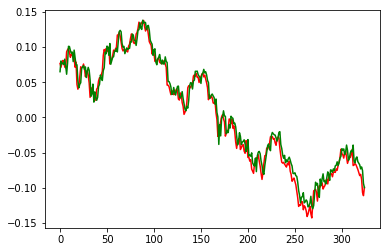

In [31]:
result_print = results[0].flatten()
plt.figure()
plt.plot(list(range(len(labels))), labels, color='r')  #红线为真实值
plt.plot(list(range(len(result_print))), result_print, color='g')  #绿线为预测值
plt.show()
